In [2]:
# 导入必要的库
import matplotlib as mpl
import matplotlib.pyplot as plt
# 在Jupyter notebook中内联显示图表
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm  # 进度条库
import torch
import torch.nn as nn
import torch.nn.functional as F

# 打印Python版本信息
print(sys.version_info)

# 打印各个库的版本信息
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

# 设置设备：如果有GPU则使用GPU，否则使用CPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=12, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.2
sklearn 1.6.1
torch 2.9.0+cu126
cuda:0


In [3]:
import json
token = {"username":"cskaoyan","key":"ff99d9d7ff71704e3e761217ceec03c5"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [4]:
!cat /content/kaggle.json

{"username": "cskaoyan", "key": "ff99d9d7ff71704e3e761217ceec03c5"}

In [5]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [6]:
!kaggle competitions download -c cifar-10

 97% 691M/715M [00:11<00:00, 111MB/s] 
100% 715M/715M [00:11<00:00, 67.5MB/s]


In [7]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [8]:
%pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 2.6 MB/s eta 0:00:00


In [9]:
!cp sampleSubmission.csv trainLabels.csv /content/competitions/cifar-10

In [10]:
!ls /content/competitions/cifar-10/

cifar-10.zip  sampleSubmission.csv  train  trainLabels.csv


In [ ]:
import py7zr
b = py7zr.SevenZipFile(r'./test.7z', 'r')
a.extractall(path=r'./competitions/cifar-10/')
b.close()

# 数据预处理

In [11]:
from pathlib import Path

DATA_DIR = Path("/content/competitions/cifar-10")

train_lables_file = DATA_DIR / "trainLabels.csv"
test_csv_file = DATA_DIR / "sampleSubmission.csv" #测试集模板csv文件
train_folder = DATA_DIR / "train"
test_folder = DATA_DIR / "test"


#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]
# INSERT_YOUR_CODE
import pandas as pd

def load_image_paths_and_labels(labels_csv_path, images_folder):
    """
    读取labels_csv_path（trainLabels.csv），为每张图片拼接完整路径，并返回[(img_path, label), ...]的列表
    """
    df = pd.read_csv(labels_csv_path)
    items = []
    for idx, row in df.iterrows():
        img_name = row['id']  # 假设csv第一列是id（去掉.jpg后缀的文件名）
        label = row['label']
        img_path = images_folder / f"{img_name}.png"  # cifar10可能是png，也可能是jpg，请确保格式一致
        if not img_path.exists():
            img_path = images_folder / f"{img_name}.jpg"
        items.append( (str(img_path), label) )
    return items

# 示例调用方法
train_items = load_image_paths_and_labels(train_lables_file, train_folder)
test_items = load_image_paths_and_labels(test_csv_file, test_folder)

import pprint
pprint.pprint(train_items[:5])



[('/content/competitions/cifar-10/train/1.png', 'frog'),
 ('/content/competitions/cifar-10/train/2.png', 'truck'),
 ('/content/competitions/cifar-10/train/3.png', 'truck'),
 ('/content/competitions/cifar-10/train/4.png', 'deer'),
 ('/content/competitions/cifar-10/train/5.png', 'automobile')]


In [12]:
pprint.pprint(test_items[:5])

[('/content/competitions/cifar-10/test/1.jpg', 'cat'),
 ('/content/competitions/cifar-10/test/2.jpg', 'cat'),
 ('/content/competitions/cifar-10/test/3.jpg', 'cat'),
 ('/content/competitions/cifar-10/test/4.jpg', 'cat'),
 ('/content/competitions/cifar-10/test/5.jpg', 'cat')]


In [13]:
# INSERT_YOUR_CODE
import pandas as pd

# 将train_items分为45000条用于训练，5000条用于验证
train_items_ = train_items[:45000]
valid_items_ = train_items[45000:]

# 转为DataFrame
train_df = pd.DataFrame(train_items_, columns=["img_path", "label"])
valid_df = pd.DataFrame(valid_items_, columns=["img_path", "label"])
test_df = pd.DataFrame(test_items, columns=["img_path", "label"])


In [44]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Cifar10Dataset(Dataset):
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }
    label_to_idx = {label: idx for idx, label in enumerate(class_names)} # 类别映射为idx
    idx_to_label = {idx: label for idx, label in enumerate(class_names)} # idx映射为类别,为了test使用
    def __init__(self, mode, transform=None):
        self.df = self.df_map.get(mode, None) # 获取对应模式的df，不同字符串对应不同模式
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))
        # assert self.df, "df is None"
        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.df.iloc[index] # 获取图片路径和标签
        img = Image.open(img_path).convert('RGB')
        # # img 转换为 channel first
        # img = img.transpose((2, 0, 1))
        # transform
        img = self.transform(img) # 数据增强
        # label 转换为 idx
        label = self.label_to_idx[label]
        return img, label

    def __len__(self):
        return self.df.shape[0] # 返回df的行数,样本数

IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transforms_train = transforms.Compose([
        # resize
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), #缩放
        # random rotation 40
        transforms.RandomRotation(40), #随机旋转
        # horizaontal flip
        transforms.RandomHorizontalFlip(),  #随机水平翻转
        transforms.ToTensor(), #转换为tensor
        transforms.Normalize(mean, std) #标准化
    ]) #数据增强

transforms_eval = transforms.Compose([
        # resize
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
# ToTensor还将图像的维度从[height, width, channels]转换为[channels, height, width]。
train_ds = Cifar10Dataset("train", transforms_train)
eval_ds = Cifar10Dataset("eval", transforms_eval)

In [15]:

# 对train_ds计算均值和标准差
# from torch.utils.data import DataLoader
# import torch
#
# loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=2)
#
# mean = torch.zeros(3)
# std = torch.zeros(3)
# n_pixels = 0
#
# for images, _ in loader:  # images: [B, 3, H, W]
#     batch_pixels = images.shape[0] * images.shape[2] * images.shape[3]
#     mean += images.sum([0, 2, 3])
#     std += (images ** 2).sum([0, 2, 3])
#     n_pixels += batch_pixels
#
# mean /= n_pixels
# std = torch.sqrt(std / n_pixels - mean ** 2)
#
# print("train_ds按通道均值:", mean)
# print("train_ds按通道标准差:", std)



In [16]:
from torch.utils.data import DataLoader

# 创建训练集和验证集的DataLoader
batch_size = 32

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,  # 训练时打乱数据
)

test_loader = DataLoader(
    eval_ds,
    batch_size=batch_size,
    shuffle=False,  # 测试时不需要打乱
)

print(f"训练集DataLoader批次数: {len(train_loader)}")
print(f"测试集DataLoader批次数: {len(test_loader)}")
print(f"每个批次大小: {batch_size}")

# 查看一个批次的数据
for batch_images, batch_labels in train_loader:
    print(f"批次图像张量形状: {batch_images.shape}")
    print(f"批次标签张量形状: {batch_labels.shape}")
    print(batch_labels)
    break

训练集DataLoader批次数: 1407
测试集DataLoader批次数: 157
每个批次大小: 32
批次图像张量形状: torch.Size([32, 3, 32, 32])
批次标签张量形状: torch.Size([32])
tensor([4, 4, 8, 5, 4, 8, 2, 4, 0, 4, 3, 6, 8, 8, 6, 0, 3, 3, 9, 2, 9, 9, 5, 8,
        4, 3, 3, 2, 2, 1, 5, 0])


# 搭建模型

In [17]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),# 批标准化，在批次上做归一化
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"), #输出尺寸（128，32，32）
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2), #输出尺寸（128，16，16）
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"), #输出尺寸（256，16，16）
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),#输出尺寸（256，8，8）
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"), #输出尺寸（512，8，8）
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2), #输出尺寸（512，4，4）
            nn.Flatten(), #展平
            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        ) #Sequential自动连接各层，把各层的输出作为下一层的输入

    def forward(self, x):
        return self.model(x)


# 初始化模型
model = CNN(num_classes=len(class_names))


In [18]:
128*16*16*256

8388608

In [19]:
# 使用随机输入对模型进行一次前向计算以验证模型结构是否正确
import torch

dummy_input = torch.randn(32, 3, 32, 32)
output = model(dummy_input) #前向传播/前向计算/正向传播
print(f"Output shape: {output.shape}")


Output shape: torch.Size([32, 10])


In [20]:
# 输出model每一层的参数量
total_params = 0  # 初始化总参数量为0
print("各层参数量统计：")  # 打印参数统计表头
for name, param in model.named_parameters():  # 遍历模型中所有需要优化的参数
    if param.requires_grad:  # 只有需要梯度更新的参数才统计
        num_params = param.numel()  # 计算当前参数的元素总数
        total_params += num_params  # 更新总参数量
        print(f"{name}: {num_params}")  # 输出当前层的参数量
print(f"模型总参数量: {total_params}")  # 输出模型总参数量


各层参数量统计：
model.0.weight: 3456
model.0.bias: 128
model.2.weight: 128
model.2.bias: 128
model.3.weight: 147456
model.3.bias: 128
model.5.weight: 128
model.5.bias: 128
model.7.weight: 294912
model.7.bias: 256
model.9.weight: 256
model.9.bias: 256
model.10.weight: 589824
model.10.bias: 256
model.12.weight: 256
model.12.bias: 256
model.14.weight: 1179648
model.14.bias: 512
model.16.weight: 512
model.16.bias: 512
model.17.weight: 2359296
model.17.bias: 512
model.19.weight: 512
model.19.bias: 512
model.22.weight: 4194304
model.22.bias: 512
model.24.weight: 5120
model.24.bias: 10
模型总参数量: 8779914


In [21]:
32*3*3*64

18432

# 训练

In [22]:
import torch.nn as nn
import torch.optim as optim

# 初始化交叉熵损失函数，内部会做softmax
criterion = nn.CrossEntropyLoss()

# 初始化优化器（这里选用Adam，也可以使用SGD等）
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
import wangdao_train
# 假设train_loader和val_loader已定义，device已经设为"cuda"或"cpu"
trainer = wangdao_train.Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    eval_step=100
)

# 设定训练轮数
num_epochs = 20

# 开始训练
trainer.train(num_epochs)


[Step 100] Val Loss: 1.9420 Val Acc: 0.2986
[Step 200] Val Loss: 1.7162 Val Acc: 0.3620
[Step 300] Val Loss: 1.5671 Val Acc: 0.4182
[Step 400] Val Loss: 1.5808 Val Acc: 0.4220
[Step 500] Val Loss: 1.5748 Val Acc: 0.4208
[Step 600] Val Loss: 1.4671 Val Acc: 0.4476
[Step 700] Val Loss: 1.4573 Val Acc: 0.4696
[Step 800] Val Loss: 1.3849 Val Acc: 0.4970
[Step 900] Val Loss: 1.4267 Val Acc: 0.4770
[Step 1000] Val Loss: 1.3225 Val Acc: 0.5228
[Step 1100] Val Loss: 1.3342 Val Acc: 0.5146
[Step 1200] Val Loss: 1.2616 Val Acc: 0.5400
[Step 1300] Val Loss: 1.2686 Val Acc: 0.5490
[Step 1400] Val Loss: 1.4220 Val Acc: 0.5186
Epoch [1/20]  Train Loss: 1.6156  Train Acc: 0.4201
[Step 1500] Val Loss: 1.1371 Val Acc: 0.5906
[Step 1600] Val Loss: 1.1294 Val Acc: 0.5966
[Step 1700] Val Loss: 1.0736 Val Acc: 0.6200
[Step 1800] Val Loss: 1.1520 Val Acc: 0.5832
[Step 1900] Val Loss: 1.0713 Val Acc: 0.6278
[Step 2000] Val Loss: 1.0447 Val Acc: 0.6324
[Step 2100] Val Loss: 1.0109 Val Acc: 0.6502
[Step 2200] 

KeyboardInterrupt: 

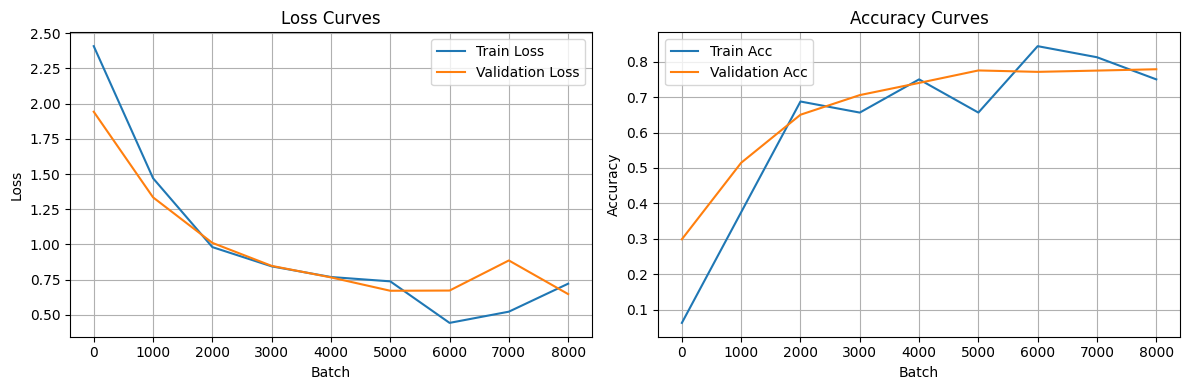

In [24]:
trainer.plot_curves()


In [26]:
!ls

competitions  sample_data	    train.7z
kaggle.json   sampleSubmission.csv  trainLabels.csv
__pycache__   test.7z		    wangdao_train.py


In [37]:
!ls /content/competitions/cifar-10/test/1.png

/content/competitions/cifar-10/test/1.png


In [38]:
test_items = load_image_paths_and_labels(test_csv_file, test_folder)

In [39]:
test_df = pd.DataFrame(test_items, columns=["img_path", "label"])
test_df.head()

,img_path,label
0,/content/competitions/cifar-10/test/1.png,cat
1,/content/competitions/cifar-10/test/2.png,cat
2,/content/competitions/cifar-10/test/3.png,cat
3,/content/competitions/cifar-10/test/4.png,cat
4,/content/competitions/cifar-10/test/5.png,cat


In [45]:
# 构建test_ds并推理，预测结果写入csv

# 假设Cifar10Dataset类、transforms_eval和idx_to_label已定义
test_ds = Cifar10Dataset("test", transforms_eval)
test_loader_final = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False)

all_preds = []
model.eval()
with torch.no_grad():
    for data in test_loader_final:
        images = data[0]
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy().tolist())

# 利用idx_to_label将id转换为类别名
all_labels = [Cifar10Dataset.idx_to_label[idx] for idx in all_preds]

import pandas as pd
# 生成带id的DataFrame
df = pd.DataFrame({
    "id": list(range(1,len(all_labels)+1)),
    "label": all_labels
})
df.to_csv("cifar10_test_pred.csv", index=False)
